Importing libraries

In [1]:
import os
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import nltk
import string
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

nltk.download('stopwords')
from nltk.corpus import stopwords

import spacy

# Load the English language model
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/homanregmi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Importing JSON's

In [2]:
df_yelp_business = pd.read_json('../raw data/yelp_academic_dataset_business.json', lines=True)
df_yelp_business.fillna('NA', inplace=True)
df_yelp_review_iter = pd.read_json('../raw data/yelp_academic_dataset_review.json', chunksize=100000, lines=True)

In [3]:
# we want to make sure we only work with restaurants -- nothing else
df_yelp_business = df_yelp_business[df_yelp_business['categories'].str.contains('Restaurants')]
print('Final Shape: ',df_yelp_business.shape)

Final Shape:  (57173, 15)


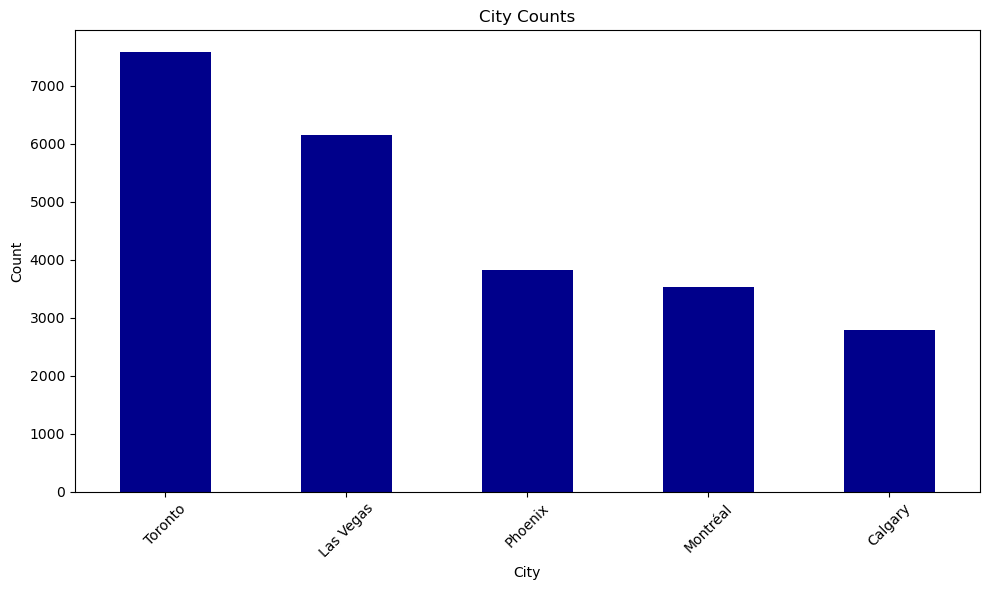

In [4]:
# Get the counts of each city
city_counts = df_yelp_business['city'].value_counts().head()

# Create a bar chart
plt.figure(figsize=(10, 6))  # Set the figure size
city_counts.plot(kind='bar', color='darkblue')  # Create a bar chart with a specified color
plt.title('City Counts')  # Set the title of the chart
plt.xlabel('City')  # Set the x-axis label
plt.ylabel('Count')  # Set the y-axis label
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed

# Show the chart
plt.tight_layout()  # Ensure that the labels fit within the figure
plt.show()

In [5]:
# List of city names to filter
cities_to_filter = ['Toronto', 'Las Vegas', 'Phoenix']          # You can choose the city as per your wish

# Filter the DataFrame based on the city names
df_yelp_business = df_yelp_business[df_yelp_business['city'].isin(cities_to_filter)]

# Display the filtered DataFrame
df_yelp_business

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
11,tZnSodhPwNr4bzrwJ1CSbw,Southern Accent Restaurant,Palmerston,595 Markham Street,Toronto,ON,M6G 2L7,43.664125,-79.411886,4.0,146,0,"{'Alcohol': 'full_bar', 'Ambience': '{'romanti...","Cajun/Creole, Southern, Restaurants","{'Tuesday': '17:0-1:0', 'Wednesday': '17:0-1:0..."
12,_c3ixq9jYKxhLUB0czi0ug,Original Hamburger Works,,2801 N 15th Ave,Phoenix,AZ,85007,33.479807,-112.091188,4.0,277,1,"{'Alcohol': 'full_bar', 'Ambience': '{'romanti...","Bars, Sports Bars, Dive Bars, Burgers, Nightli...","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."
19,vJIuDBdu01vCA8y1fwR1OQ,CakesbyToi,,"3940 Martin Luther King Blvd, Ste 101",Las Vegas,NV,89106,36.192284,-115.159272,1.5,3,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","American (Traditional), Food, Bakeries, Restau...","{'Tuesday': '11:0-18:0', 'Wednesday': '11:0-18..."
22,3ByGQOVgds2YEu6kzl-XEQ,Rib Shop,,4131 N 83rd Ave,Phoenix,AZ,85033,33.495298,-112.236076,2.5,3,1,"{'Ambience': '{'romantic': False, 'intimate': ...","Nightlife, Bars, American (Traditional), Sport...",NA
24,CeuTRtwsq6w5rztGOyNMPg,Salsitas,,7745 W Thomas Rd,Phoenix,AZ,85033,33.479671,-112.225173,2.5,14,1,"{'BusinessAcceptsCreditCards': 'True', 'GoodFo...","Mexican, Restaurants",NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188518,P4atiaghQt2lnMUtO-SLwQ,Subway,,"3201 E Thomas Rd, Ste 101",Phoenix,AZ,85018,33.480112,-112.012566,3.0,8,1,"{'HasTV': 'False', 'RestaurantsDelivery': 'Fal...","Restaurants, Fast Food, Sandwiches",NA
188520,8w2Mzdz-JKy3qOpndK1Wqw,Subway,Eastside,3519 S Maryland Pkwy,Las Vegas,NV,89169,36.125669,-115.137639,2.0,12,1,"{'Alcohol': 'none', 'Ambience': '{'romantic': ...","Sandwiches, Fast Food, Restaurants",NA
188538,W5d8iNog90R-qw43m5dGwg,Café Polonez,Roncesvalles,195 Roncesvalles Avenue,Toronto,ON,M6R 2L5,43.645129,-79.448348,4.5,211,1,"{'Alcohol': 'full_bar', 'Ambience': '{'romanti...","Polish, Food, Specialty Food, Breakfast & Brun...","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."
188567,0zGeYN8ReYwVj27U7EHOJA,American Cafe,The Strip,3049 Las Vegas Blvd S,Las Vegas,NV,89109,36.131516,-115.164565,2.5,7,1,"{'Ambience': '{'romantic': False, 'intimate': ...","Delis, Restaurants, American (Traditional)",NA


Because reviews are too big, we will read them in chunks, and make sure we delete reviews of places that are not in our list of businesses filtered earlier. Note here we choose 5 chunks, but we could have chosen any number (larger numbers will give MemoryError later on).

In [6]:
df_yelp_review = pd.DataFrame()
i=0
for df in df_yelp_review_iter:
    df = df[df['business_id'].isin(df_yelp_business['business_id'])]
    df_yelp_review = pd.concat([df_yelp_review, df])
    i=i+1
    print(i)
    if i==4: break

1
2
3
4


In [7]:
df_yelp_review

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,x7mDIiDB3jEiPGPHOmDzyw,msQe1u7Z_XuqjGoqhB0J5g,iCQpiavjjPzJ5_3gPD5Ebg,2,2011-02-25,The pizza was okay. Not the best I've had. I p...,0,0,0
1,dDl8zu1vWPdKGihJrwQbpw,msQe1u7Z_XuqjGoqhB0J5g,pomGBqfbxcqPv14c3XH-ZQ,5,2012-11-13,I love this place! My fiance And I go here atl...,0,0,0
2,LZp4UX5zK3e-c5ZGSeo3kA,msQe1u7Z_XuqjGoqhB0J5g,jtQARsP6P-LbkyjbO1qNGg,1,2014-10-23,Terrible. Dry corn bread. Rib tips were all fa...,3,1,1
3,Er4NBWCmCD4nM8_p1GRdow,msQe1u7Z_XuqjGoqhB0J5g,elqbBhBfElMNSrjFqW3now,2,2011-02-25,Back in 2005-2007 this place was my FAVORITE t...,2,0,0
4,jsDu6QEJHbwP2Blom1PLCA,msQe1u7Z_XuqjGoqhB0J5g,Ums3gaP2qM3W1XcA5r6SsQ,5,2014-09-05,Delicious healthy food. The steak is amazing. ...,0,0,0
...,...,...,...,...,...,...,...,...,...
399975,xffSTWGaWQi33zqxQAmhRw,4ENdbgRsF7c3ynfc8jUizQ,fZVkbNNWjMxuWzNi4Uvufg,4,2011-04-04,"Very good burgers, buns are toasted.....jalape...",1,0,0
399976,QbqsDxS2Jxse1Or6ZAUr5A,0D6VlA_DGbvsfE7eL9tRsw,S6TMBqrsi4PLRFoQFPScjQ,1,2012-03-12,Disappointing overcooked tofu cubes. Food did...,3,0,0
399992,qKnXSTRWbZg2YyPcvR_udw,q-dOajXzcD4XZu1FzrSs2g,K7lWdNUhCbcnEvI0NhGewg,5,2017-06-05,Being a foodie with a gluten allergy can somet...,1,1,1
399994,u1qI0SoM2ss69uy0FThxsQ,9P0QdsChFBiMfYv-EzyDSw,ygJshif4VuxL1ijnRJnuYA,5,2015-03-31,Such a neat place to eat! The servers were won...,0,0,0


In [8]:
#Save this df_yelp_review whenever you change the cities as this is required for the dashboard
df_yelp_review.to_csv('../processed data/df_yelp_review.csv', index = False)

Also make sure we only get businesses that already show up in our review list and delete the rest.

In [9]:
df_yelp_business = df_yelp_business[df_yelp_business['business_id'].isin(df_yelp_review['business_id'])]

In [10]:
#Save this df_yelp_business whenever you change the cities as this is required for the dashboard
df_yelp_business.to_csv('../processed data/df_yelp_business.csv', index = False)

In [11]:
print('Final businesses shape: ', df_yelp_business.shape)
print('Final review shape: ', df_yelp_review.shape)

Final businesses shape:  (12626, 15)
Final review shape:  (106912, 9)


cleaning the reviews

In [12]:
def clean_text(text):
    ## Remove puncuation
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)
    
    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)    
    return text

In [13]:
%%time
df_yelp_review['text'] = df_yelp_review['text'].apply(clean_text)

CPU times: user 28 s, sys: 3.45 s, total: 31.5 s
Wall time: 31.9 s


In [14]:
# Group reviews by 'business_id' and aggregate review text and average stars
aggregated_reviews = df_yelp_review.groupby('business_id').agg({
    'text': lambda x: ' '.join(x),
    'stars': 'mean'  # Calculate the mean (average) of stars
}).reset_index()

# Rename columns for clarity
aggregated_reviews.columns = ['business_id', 'text', 'average_stars']

# Verify the new DataFrame
aggregated_reviews

,business_id,text,average_stars
0,--9e1ONYQuAa-CB_Rrw7Tw,real evening + apps bbq shrimp great there exp...,4.084337
1,--DaPTJW3-tB1vP-PfdTEg,excellent friendly service ! nice clean restau...,3.600000
2,--SrzpvFLwP_YFwB_Cetow,first time writing review yelp disgusted dish ...,3.000000
3,--g-a85VwrdZJNf0R95GcQ,super fresh food great prices ala carte entree...,4.500000
4,-050d_XIor1NpCuWkbIVaQ,one best breakfast places phoenix arrived late...,3.934783
...,...,...,...
12621,zyw5DjrRks7a8OhmBsgCQQ,favourite local bar ! they have got great drin...,3.500000
12622,zz3CqZhNx2rQ_Yp6zHze-A,love + + how know paid 22 burger lunch absolut...,3.888889
12623,zzsU528uoRB6qZUGhKDa6w,nice place eat take mike now cafeteria still s...,5.000000
12624,zzvlwkcNR1CCqOPXwuvz2A,mislabeling food + + visited father nephew fir...,1.000000


In [15]:
#Save this aggregated_reviews whenever you change the cities as this is required for the dashboard
aggregated_reviews.to_csv('../processed data/aggregated_reviews.csv',index = False)

Getting all the categories in to a single string and getting top iduvidual categories in to columns

In [16]:
# Check if the 'attributes' column exists in the DataFrame
if 'attributes' in df_yelp_business.columns:
    # Concatenate all the words in the 'attributes' column into one string
    combined_attributes = ' '.join(df_yelp_business['categories'].astype(str))
    
    # Optionally, remove any extra spaces and leading/trailing whitespaces
    combined_attributes = ' '.join(combined_attributes.split())

    # Print or store the result
    print(combined_attributes)
else:
    print("The 'attributes' column does not exist in the DataFrame.")

Cajun/Creole, Southern, Restaurants Bars, Sports Bars, Dive Bars, Burgers, Nightlife, Sandwiches, Restaurants Mexican, Restaurants Restaurants, Food, Canadian (New), Coffee & Tea Fast Food, Restaurants, Sandwiches Beer, Wine & Spirits, Italian, Food, American (Traditional), Breakfast & Brunch, Restaurants Event Planning & Services, Soup, Salad, Mexican, Caterers, Restaurants Caribbean, Food, Bakeries, Restaurants Restaurants, Food, Coffee & Tea, Breakfast & Brunch Nightlife, Wine Bars, Indian, Restaurants, Bars American (Traditional), Burgers, Fast Food, Restaurants Nightlife, Bars, Restaurants, Canadian (New), Pubs Salad, Chicken Wings, Sandwiches, Pizza, Restaurants Chicken Wings, Restaurants, Fast Food Restaurants, Pizza Mexican, Restaurants Asian Fusion, Taiwanese, Restaurants Restaurants, Food, Indian American (Traditional), Comfort Food, Barbeque, Restaurants Restaurants, Salad, Fast Food, Mexican Coffee & Tea, Grocery, Latin American, Restaurants, Food Southern, Chicken Wings, F

In [17]:
def clean_text(text):
    # Tokenize the text into words
    words = text.split()

    # Remove punctuation and convert to lowercase
    words = [word.lower().strip(string.punctuation) for word in words]

    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    words = [word for word in words if word not in stop_words]

    # Rejoin the words into a clean text
    clean_text = ' '.join(words)

    return clean_text


# Clean the text
cleaned_text = clean_text(combined_attributes)
print(cleaned_text)

cajun/creole southern restaurants bars sports bars dive bars burgers nightlife sandwiches restaurants mexican restaurants restaurants food canadian new coffee  tea fast food restaurants sandwiches beer wine  spirits italian food american traditional breakfast  brunch restaurants event planning  services soup salad mexican caterers restaurants caribbean food bakeries restaurants restaurants food coffee  tea breakfast  brunch nightlife wine bars indian restaurants bars american traditional burgers fast food restaurants nightlife bars restaurants canadian new pubs salad chicken wings sandwiches pizza restaurants chicken wings restaurants fast food restaurants pizza mexican restaurants asian fusion taiwanese restaurants restaurants food indian american traditional comfort food barbeque restaurants restaurants salad fast food mexican coffee  tea grocery latin american restaurants food southern chicken wings fast food american traditional restaurants mexican restaurants cafes arts  entertain

In [18]:
# Split the input text into words
words = cleaned_text.split()

# Count the occurrences of each word
word_counts = Counter(words)

# Create a DataFrame from the word counts
word_counts_df = pd.DataFrame.from_dict(word_counts, orient='index', columns=['Count']).reset_index()
word_counts_df = word_counts_df.rename(columns={'index': 'Word'})

# Sort the DataFrame by word counts in descending order
sorted_word_counts_df = word_counts_df.sort_values(by='Count', ascending=False)

# Filter the DataFrame to include only words with a count of 500 or more
filtered_word_counts_df = sorted_word_counts_df[sorted_word_counts_df['Count'] >= 500]
# Display the filtered DataFrame
print(filtered_word_counts_df)

           Word  Count
2   restaurants  12628
10         food   5230
3          bars   3715
20     american   2495
7     nightlife   1894
12          new   1509
21  traditional   1354
8    sandwiches   1329
9       mexican   1285
15         fast   1259
22    breakfast   1236
23       brunch   1233
36        pizza   1196
19      italian   1042
6       burgers   1033
58      chinese    916
61     japanese    799
14          tea    767
44        cafes    729
13       coffee    706
26     services    662
94      seafood    627
24        event    608
68        sushi    603
34      chicken    572
37        asian    550
38       fusion    540
11     canadian    517
25     planning    512


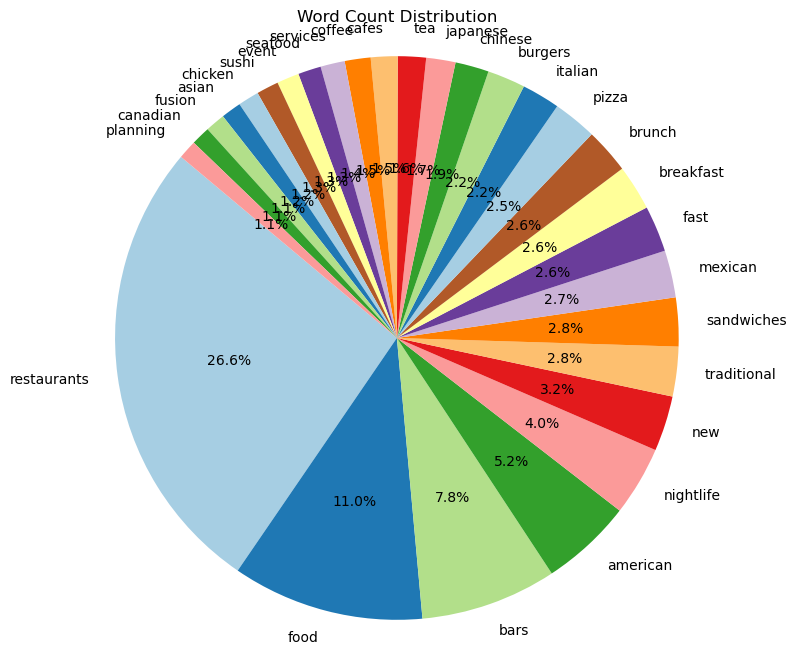

In [19]:
# Create a pie chart
plt.figure(figsize=(8, 8))  # Set the figure size
plt.pie(filtered_word_counts_df['Count'].tolist(), labels=filtered_word_counts_df['Word'].tolist(), autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)

# Set the title
plt.title('Word Count Distribution')

# Display the pie chart
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [20]:
# Create an empty DataFrame with column names from filtered_word_counts_df
word_columns = filtered_word_counts_df['Word'].tolist()
result_df = pd.DataFrame(columns=word_columns)

result_df = pd.DataFrame()
# Iterate through df_yelp_business and mark 1 in result_df
for index, row in df_yelp_business.iterrows():
    categories = row['categories'].split(', ')
    result_row = {'business_id': row['business_id']}  # Include 'business_id' in the result row
    for word in word_columns:
        if any(word.lower() == category.strip().lower() for category in categories):
            result_row[word] = 1
        else:
            result_row[word] = 0
    
    # Convert the dictionary to a DataFrame
    row_df = pd.DataFrame([result_row])

    # Concatenate the row DataFrame with the existing DataFrame
    result_df = pd.concat([result_df, row_df], ignore_index=True)
    
# Fill NaN values with 0
result_df = result_df.fillna(0)


In [21]:
result_df.head(5)

,business_id,restaurants,food,bars,american,nightlife,new,traditional,sandwiches,mexican,...,coffee,services,seafood,event,sushi,chicken,asian,fusion,canadian,planning
0,tZnSodhPwNr4bzrwJ1CSbw,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,_c3ixq9jYKxhLUB0czi0ug,1,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,CeuTRtwsq6w5rztGOyNMPg,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,PMDlKLd0Mxj0ngCpuUmE5Q,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,kgffcoxT6BQp-gJ-UQ7Czw,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
#Save this result_df whenever you change the cities as this is required for the dashboard
result_df.to_csv('../processed data/result_df.csv',index = False)

In [23]:
categories = result_df.drop('business_id', axis=1).columns.unique()
categories

Index(['restaurants', 'food', 'bars', 'american', 'nightlife', 'new',
       'traditional', 'sandwiches', 'mexican', 'fast', 'breakfast', 'brunch',
       'pizza', 'italian', 'burgers', 'chinese', 'japanese', 'tea', 'cafes',
       'coffee', 'services', 'seafood', 'event', 'sushi', 'chicken', 'asian',
       'fusion', 'canadian', 'planning'],
      dtype='object')

Model 1

In [24]:
# Function to clean and tokenize input text
def clean_input_text(text):
    text = text.lower()
    text = ' '.join(text.split())  # Remove extra spaces
    return text

# Function to extract city from input text
def extract_city_from_input(text, cities):
    for city in cities:
        if city in text:
            return city
    return None

# Function to extract category from input text using fuzzy matching
def extract_category_from_input(text, categories):
    # Clean and preprocess the user input text
    text = clean_input_text(text)
    
    # Tokenize and analyze the user input text with spaCy
    doc = nlp(text)
    
    # Initialize a list to store relevant categories
    relevant_categories = []
    
    # Search for known categories based on NLP analysis
    for category in categories:
        cleaned_category = clean_input_text(category)
        # Check if any token in the input text partially matches the category name
        if any(token.text in cleaned_category.lower() for token in doc):
            relevant_categories.append(category)
    
    return relevant_categories if relevant_categories else None

# Example list of cities and categories (replace with your data)
cities = df_yelp_business['city'].unique().tolist()

city_input = input("Enter the city of your preferences: ")
category_input = input("Enter the category of your preferences: ")
stars = float(input("Enter the star rating of your preferences: "))

# Extract the city from user input text
city = extract_city_from_input(city_input, cities)

# Extract the category from user input text
Category = extract_category_from_input(category_input, categories)

print("Category:", Category)
print("City:", city)
print("Star:", stars)

Enter the city of your preferences: Toronto, Las Vegas, Phoenix
Enter the category of your preferences: Restaurant
Enter the star rating of your preferences: 2.7
Category: ['restaurants']
City: Toronto
Star: 2.7


In [25]:
# Create the input DataFrame for prediction
ab = pd.DataFrame({category: [1] for category in Category})
ab

,restaurants
0,1


Building KNN model a finding the recommendations for the input

In [26]:
# Column name to exclude
column_to_exclude = 'business_id'

# Select all columns except the one to exclude
X_train = result_df.drop(columns=[column_to_exclude])

# To change the input dataframe structure as per the result_df to fit in the model
#Fill remaining columns with 0
for column in X_train.columns:
    if column not in ab.columns:
        ab[column] = 0

# Reorder columns to match X_train
ab = ab[X_train.columns]

columns_to_encode = X_train.columns

# Convert categorical columns to numerical using One-Hot Encoding
abc_encoded = pd.get_dummies(result_df, columns=columns_to_encode).drop('business_id', axis=1)
ab_encoded = pd.get_dummies(ab, columns=columns_to_encode)

# Make sure both DataFrames have the same columns by aligning them
abc_encoded, ab_encoded = abc_encoded.align(ab_encoded, axis=1, fill_value=0)

# Initialize and fit the KNN model
knn_model = NearestNeighbors(n_neighbors=10)  # Change the number of neighbors as needed
knn_model.fit(abc_encoded)  # Drop the 'business_id' column for modeling

# Find the k-nearest neighbors for your input data
distances, indices = knn_model.kneighbors(ab_encoded)

# Get the recommended business_ids
recommendations = result_df.iloc[indices[0]]['business_id']

print(recommendations)

5770    PqiyDxlN_o7p16xTeVQDEQ
5769    OcHZMxSYubLUg64aBU27sA
5792    F3JfTKaytuIXQHwLcQfNug
5791    gRCEObNuHtI61xR32ytqNQ
5790    kktb-uIc2YjNWOdbW4ktCg
5788    G2yY7OdcwX71jCkKP1-Efg
5779    ae1UMj40ITqSYa5MQM8zTA
5776    17K0u4eyrm5rZBo5FybQtA
5775    XTud0c9F7oRCeNI3rULk7w
5801    sYx7UnIj_iP3QwqJoVq-Pg
Name: business_id, dtype: object


In [27]:
# Filter df_yelp_business to get the rows with business_ids in recommendations
recommended_businesses = df_yelp_business[df_yelp_business['business_id'].isin(recommendations)]

# Now, recommended_businesses contains the rows for the recommended businesses
recommended_businesses

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
86495,OcHZMxSYubLUg64aBU27sA,Nathan's Famous,The Strip,"Fashion Show Mall Food Court, 3200 Las Vegas B...",Las Vegas,NV,89109,36.127308,-115.171459,2.5,11,1,"{'Alcohol': 'none', 'Ambience': '{'romantic': ...","Hot Dogs, Cheesesteaks, American (New), Restau...",NA
86496,PqiyDxlN_o7p16xTeVQDEQ,Dine on 3,,1 Yorkdale Road,Toronto,ON,M6A 2T9,43.726466,-79.452973,3.5,30,1,"{'Alcohol': 'none', 'Ambience': '{'romantic': ...","Restaurants, Food Court, Fast Food",NA
86600,XTud0c9F7oRCeNI3rULk7w,Carribean Queen Metro,Ryerson,10 Dundas Street,Toronto,ON,M5B 0A1,43.656373,-79.381061,3.5,12,1,"{'BikeParking': 'False', 'GoodForKids': 'True'...","Caribbean, Restaurants",NA
86606,17K0u4eyrm5rZBo5FybQtA,Azool Grill,,3134 W Carefree Hwy,Phoenix,AZ,85086,33.800039,-112.128239,3.5,74,1,"{'Alcohol': 'full_bar', 'Ambience': '{'romanti...","American (Traditional), Restaurants","{'Monday': '10:0-2:0', 'Tuesday': '10:0-2:0', ..."
86613,ae1UMj40ITqSYa5MQM8zTA,93 Harbord,,93 Harbord Street,Toronto,ON,M5S 1G4,43.662751,-79.403605,3.0,18,0,"{'Alcohol': 'full_bar', 'Ambience': '{'romanti...","Middle Eastern, Restaurants","{'Monday': '17:30-22:0', 'Tuesday': '17:30-22:..."
86743,G2yY7OdcwX71jCkKP1-Efg,Potman Hotpot,Milliken,"633 Silver Star Boulverd, Unit 110-111",Toronto,ON,M1V 5N1,43.82214,-79.298508,4.0,33,1,"{'Alcohol': 'beer_and_wine', 'Ambience': '{'ro...","Restaurants, Hot Pot","{'Monday': '16:0-0:0', 'Tuesday': '16:0-0:0', ..."
86817,kktb-uIc2YjNWOdbW4ktCg,Delina Restaurant,The Beach,1891 Queen Street E,Toronto,ON,M4L 1H3,43.668693,-79.305142,4.0,26,1,"{'Alcohol': 'none', 'Ambience': '{'romantic': ...","Fast Food, Middle Eastern, Restaurants",NA
86851,gRCEObNuHtI61xR32ytqNQ,Palace Station Hotel & Casino,,2411 W Sahara Ave,Las Vegas,NV,89102,36.142944,-115.174743,2.5,719,1,"{'BusinessAcceptsBitcoin': 'False', 'BusinessA...","Event Planning & Services, Arts & Entertainmen...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W..."
86857,F3JfTKaytuIXQHwLcQfNug,Kavkaz,,1881 Steeles Avenue W,Toronto,ON,M3H,43.786393,-79.468829,4.5,37,1,"{'Alcohol': 'full_bar', 'Ambience': '{'romanti...","Restaurants, Canadian (New), Mediterranean, Ru...","{'Tuesday': '12:0-22:0', 'Wednesday': '12:0-22..."
86938,sYx7UnIj_iP3QwqJoVq-Pg,Euro Grill,,814 E Union Hills Rd,Phoenix,AZ,85024,33.655825,-112.062315,4.0,15,0,"{'Alcohol': 'none', 'Ambience': '{'romantic': ...","Russian, Mediterranean, Restaurants, American ...","{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'..."


Model 2

In [28]:
%%time
df_yelp_review['text'] = df_yelp_review['text'].apply(clean_text)

CPU times: user 17.3 s, sys: 3.21 s, total: 20.5 s
Wall time: 20.7 s


In [29]:
# Group reviews by 'business_id' and aggregate review text and average stars
aggregated_reviews = df_yelp_review.groupby('business_id').agg({
    'text': lambda x: ' '.join(x),
    'stars': 'mean'  # Calculate the mean (average) of stars
}).reset_index()

# Rename columns for clarity
aggregated_reviews.columns = ['business_id', 'text', 'average_stars']

freq_count = []
for item in aggregated_reviews['text']:
    count = Counter(str(item).split())
    freq_count.append(count)
aggregated_reviews['word_count'] = freq_count
aggregated_reviews.head()

,business_id,text,average_stars,word_count
0,--9e1ONYQuAa-CB_Rrw7Tw,real evening apps bbq shrimp great expect get...,4.084337,"{'real': 3, 'evening': 4, 'apps': 1, 'bbq': 10..."
1,--DaPTJW3-tB1vP-PfdTEg,excellent friendly service nice clean restaur...,3.600000,"{'excellent': 1, 'friendly': 3, 'service': 1, ..."
2,--SrzpvFLwP_YFwB_Cetow,first time writing review yelp disgusted dish ...,3.000000,"{'first': 1, 'time': 1, 'writing': 1, 'review'..."
3,--g-a85VwrdZJNf0R95GcQ,super fresh food great prices ala carte entree...,4.500000,"{'super': 1, 'fresh': 1, 'food': 2, 'great': 2..."
4,-050d_XIor1NpCuWkbIVaQ,one best breakfast places phoenix arrived late...,3.934783,"{'one': 20, 'best': 16, 'breakfast': 45, 'plac..."


Compute TF-IDF

To give more weight to informative words, we weigh them by their TF-IDF scores.

In [30]:
tfidfVect = TfidfVectorizer()
tfidf = tfidfVect.fit_transform(aggregated_reviews['text'])
print(tfidf)

  (0, 10155)	0.007659818198687238
  (0, 24352)	0.010807225937619005
  (0, 39444)	0.005550058097469478
  (0, 29625)	0.005951444316729649
  (0, 46806)	0.005415108297766762
  (0, 46526)	0.004642442280412679
  (0, 10105)	0.009052962708497163
  (0, 2173)	0.007275928622550141
  (0, 23430)	0.004964939970764715
  (0, 13214)	0.008577153081491373
  (0, 43029)	0.004655979274311591
  (0, 61291)	0.005840811077872918
  (0, 57161)	0.009393090108497707
  (0, 9175)	0.004147556135590085
  (0, 16885)	0.008443114674511568
  (0, 545)	0.00869070101719657
  (0, 21663)	0.007873857139906819
  (0, 18311)	0.004667533126163824
  (0, 28933)	0.007367881170000014
  (0, 20939)	0.005852695264623662
  (0, 38891)	0.010960109428840448
  (0, 5132)	0.007826587452248466
  (0, 21869)	0.010080575409615463
  (0, 57170)	0.005281952793820747
  (0, 31909)	0.006389468331982203
  :	:
  (12625, 10041)	0.13545378093402127
  (12625, 42878)	0.09051782025147534
  (12625, 19958)	0.08835545305174367
  (12625, 14058)	0.09344772951952748
  

In [31]:
tfidf_vocab = tfidfVect.vocabulary_

total_word_count = len(tfidf_vocab)
print(f"Total Word Count: {total_word_count}")

Total Word Count: 68725


In [32]:
agg_tfidfVect = TfidfVectorizer()
agg_tfidfVect = agg_tfidfVect.fit(aggregated_reviews['text'])

In [34]:
user_input = input("Enter a description of your preferences: ")
user_input = user_input.title()

Enter a description of your preferences: good food, night life


In [35]:
# Define a list of common stop words
stop_words = ["a", "the","there","behind", "in", "and", "on", "with", "at", "an", "of", "for", "i", "want", "to", "is", "you", "it"]

# Split the input text into words
words = user_input.split()

def remove_stopwords(words):
    # Initialize an empty list to store the filtered words
    filtered_words = []

    # Iterate through the words and keep only those not in the stop words list
    for word in words:
        if word.lower() not in stop_words:
            filtered_words.append(word)
    return filtered_words

filtered_words = remove_stopwords(words)

# Join the filtered words to form the output text
user_input_text = " ".join(filtered_words)
user_input_text = [user_input_text]
print(user_input_text)

#FINALIZED MODEL 2 WITH PERMUTATIONS
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import spacy

# Function to extract city from input text
def extract_city_from_input(text, cities):
    for city in cities:
        if city in text:
            return city
    return None

# Example list of cities and categories (replace with your data)
cities = df_yelp_business['city'].unique().tolist()

# Extract the city from user input text
city = extract_city_from_input(user_input, cities)
print("City:", city)

['Good Food, Night Life']
City: None


In [36]:
agg_tfidf = agg_tfidfVect.transform(user_input_text)
feature_names = agg_tfidfVect.get_feature_names_out()
for col in agg_tfidf.nonzero()[1]:
    print(feature_names[col], ' - ', agg_tfidf[0, col])

night  -  0.5025150115083354
life  -  0.7573460307418044
good  -  0.30528724358800996
food  -  0.2840868737390839


Training model with the tfidf of aggregated reviwes and finding 
for the input string

In [37]:
#Fitting for aggregated text 
nbrs = NearestNeighbors(n_neighbors=10).fit(tfidf)

#Finding nearest neighbours for the input string
distances, indices = nbrs.kneighbors(agg_tfidf)

In [38]:
names_similar = pd.Series(indices.flatten()).map(aggregated_reviews.reset_index()['business_id'])
names_similar

0    S0yP4IZmwVpeqxSe0R2Fvw
1    ZW0EGqx6jeBe_7ihmLykBQ
2    DjlSMGIeQNq3huXiBpFhUA
3    xywadi1Prn2yEolyVoss6w
4    zazLy5wo73tr5y9Oxjx36g
5    G7yeF8yMra1_kymdxPVCWQ
6    ouK0VptyVbggm0Z7CbXjww
7    bQ5VYGpju_cgYdUU1swRcw
8    z4_Aut97zxHEen9LXYJ9Ig
9    k0M6oh4KGwW1Tp_YA_Ywwg
dtype: object

In [39]:
# Filter df_yelp_business to get the rows with business_ids in recommendations
recommended_businesses_1 = df_yelp_business[df_yelp_business['business_id'].isin(names_similar)]

# Now, recommended_businesses contains the rows for the recommended businesses
recommended_businesses_1

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
77321,DjlSMGIeQNq3huXiBpFhUA,El Burrito Grande,,3416 W Buckeye Rd,Phoenix,AZ,85009,33.437093,-112.133094,4.5,7,0,"{'Ambience': '{'romantic': False, 'intimate': ...","Restaurants, Mexican",NA
107070,bQ5VYGpju_cgYdUU1swRcw,Perigee,Distillery District,55 Mill Street,Toronto,ON,M5A 3C4,43.650718,-79.358025,3.5,3,0,NA,"French, Restaurants, Italian","{'Tuesday': '17:30-21:30', 'Wednesday': '17:30..."
108504,zazLy5wo73tr5y9Oxjx36g,Violas Tavern,Northwest,4061 N Rancho,Las Vegas,NV,89130,36.234167,-115.228257,3.5,19,0,"{'Alcohol': 'full_bar', 'Ambience': '{'romanti...","Nightlife, Bars, Sports Bars, Active Life, Res...","{'Monday': '6:0-6:0', 'Tuesday': '6:0-6:0', 'W..."
109566,ouK0VptyVbggm0Z7CbXjww,Three Hands,Brockton Village,1532 Dundas Street W,Toronto,ON,M6K 1T5,43.649828,-79.433001,4.5,32,1,"{'Alcohol': 'full_bar', 'Ambience': '{'romanti...","Soul Food, Comfort Food, Restaurants, Bars, Ni...","{'Monday': '18:0-1:0', 'Tuesday': '18:0-2:0', ..."
111213,xywadi1Prn2yEolyVoss6w,Subway,,4102 N 24th St,Phoenix,AZ,85016,33.49538,-112.030713,3.0,9,1,"{'Alcohol': 'none', 'BusinessAcceptsCreditCard...","Restaurants, Fast Food, Sandwiches",NA
122372,z4_Aut97zxHEen9LXYJ9Ig,Angolino,The Junction,1595 Dupont Street,Toronto,ON,M6P 3S8,43.66502,-79.454234,4.5,16,0,"{'Alcohol': 'full_bar', 'Ambience': '{'romanti...","Italian, Event Planning & Services, Caterers, ...","{'Tuesday': '17:0-22:0', 'Wednesday': '17:0-22..."
154102,ZW0EGqx6jeBe_7ihmLykBQ,Jimmy John's,,7331 W Lake Mead Blvd,Las Vegas,NV,89128,36.194748,-115.252614,2.5,45,1,"{'Alcohol': 'none', 'Ambience': '{'romantic': ...","Sandwiches, Restaurants, Fast Food, Delis","{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'..."
159698,S0yP4IZmwVpeqxSe0R2Fvw,Subway,The Strip,2890 Las Vegas Blvd S,Las Vegas,NV,89109,36.136021,-115.163209,1.0,12,1,"{'Ambience': '{'romantic': False, 'intimate': ...","Restaurants, Sandwiches, Fast Food, Pizza",NA
165990,k0M6oh4KGwW1Tp_YA_Ywwg,Fat Bastard Burrito,Downtown Core,187 College Street,Toronto,ON,M5T 1P7,43.658852,-79.394438,2.5,16,1,"{'Alcohol': 'none', 'Ambience': '{'romantic': ...","Restaurants, Mexican","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."
181350,G7yeF8yMra1_kymdxPVCWQ,24 Hour Soul Food Express,Eastside,4855 Boulder Hwy,Las Vegas,NV,89121,36.117207,-115.088329,3.0,8,1,"{'BikeParking': 'False', 'BusinessAcceptsCredi...","Food, Food Delivery Services, Soul Food, Resta...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W..."


Combining dataframes of model 1 and model 2

In [40]:
Final_df = pd.concat([recommended_businesses, recommended_businesses_1], axis=0)

# If you want to reset the index of the combined DataFrame
Final_df = Final_df.reset_index(drop=True)
Final_df

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,OcHZMxSYubLUg64aBU27sA,Nathan's Famous,The Strip,"Fashion Show Mall Food Court, 3200 Las Vegas B...",Las Vegas,NV,89109,36.127308,-115.171459,2.5,11,1,"{'Alcohol': 'none', 'Ambience': '{'romantic': ...","Hot Dogs, Cheesesteaks, American (New), Restau...",NA
1,PqiyDxlN_o7p16xTeVQDEQ,Dine on 3,,1 Yorkdale Road,Toronto,ON,M6A 2T9,43.726466,-79.452973,3.5,30,1,"{'Alcohol': 'none', 'Ambience': '{'romantic': ...","Restaurants, Food Court, Fast Food",NA
2,XTud0c9F7oRCeNI3rULk7w,Carribean Queen Metro,Ryerson,10 Dundas Street,Toronto,ON,M5B 0A1,43.656373,-79.381061,3.5,12,1,"{'BikeParking': 'False', 'GoodForKids': 'True'...","Caribbean, Restaurants",NA
3,17K0u4eyrm5rZBo5FybQtA,Azool Grill,,3134 W Carefree Hwy,Phoenix,AZ,85086,33.800039,-112.128239,3.5,74,1,"{'Alcohol': 'full_bar', 'Ambience': '{'romanti...","American (Traditional), Restaurants","{'Monday': '10:0-2:0', 'Tuesday': '10:0-2:0', ..."
4,ae1UMj40ITqSYa5MQM8zTA,93 Harbord,,93 Harbord Street,Toronto,ON,M5S 1G4,43.662751,-79.403605,3.0,18,0,"{'Alcohol': 'full_bar', 'Ambience': '{'romanti...","Middle Eastern, Restaurants","{'Monday': '17:30-22:0', 'Tuesday': '17:30-22:..."
5,G2yY7OdcwX71jCkKP1-Efg,Potman Hotpot,Milliken,"633 Silver Star Boulverd, Unit 110-111",Toronto,ON,M1V 5N1,43.82214,-79.298508,4.0,33,1,"{'Alcohol': 'beer_and_wine', 'Ambience': '{'ro...","Restaurants, Hot Pot","{'Monday': '16:0-0:0', 'Tuesday': '16:0-0:0', ..."
6,kktb-uIc2YjNWOdbW4ktCg,Delina Restaurant,The Beach,1891 Queen Street E,Toronto,ON,M4L 1H3,43.668693,-79.305142,4.0,26,1,"{'Alcohol': 'none', 'Ambience': '{'romantic': ...","Fast Food, Middle Eastern, Restaurants",NA
7,gRCEObNuHtI61xR32ytqNQ,Palace Station Hotel & Casino,,2411 W Sahara Ave,Las Vegas,NV,89102,36.142944,-115.174743,2.5,719,1,"{'BusinessAcceptsBitcoin': 'False', 'BusinessA...","Event Planning & Services, Arts & Entertainmen...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W..."
8,F3JfTKaytuIXQHwLcQfNug,Kavkaz,,1881 Steeles Avenue W,Toronto,ON,M3H,43.786393,-79.468829,4.5,37,1,"{'Alcohol': 'full_bar', 'Ambience': '{'romanti...","Restaurants, Canadian (New), Mediterranean, Ru...","{'Tuesday': '12:0-22:0', 'Wednesday': '12:0-22..."
9,sYx7UnIj_iP3QwqJoVq-Pg,Euro Grill,,814 E Union Hills Rd,Phoenix,AZ,85024,33.655825,-112.062315,4.0,15,0,"{'Alcohol': 'none', 'Ambience': '{'romantic': ...","Russian, Mediterranean, Restaurants, American ...","{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'..."


In [41]:
# Filter recommended_businesses for businesses in Toronto with 3.0 stars
filtered_businesses = Final_df[(Final_df['city'] == city) & (Final_df['stars'] >= stars)]

filtered_businesses_1 = filtered_businesses.merge(
        aggregated_reviews[aggregated_reviews['average_stars'] >= stars][['business_id', 'average_stars']],
        on='business_id',
        how='inner'
    )
filtered_businesses_1

,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,business_id,average_stars


In [42]:
filtered_businesses

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours


To get the reviwes of a particular business_id

In [43]:
filter_reviews = df_yelp_review[df_yelp_review['business_id'] == "gVILTnDFDsVuVdxFVkRK7A"]

In [44]:
name = df_yelp_business[df_yelp_business['business_id'] == "gVILTnDFDsVuVdxFVkRK7A"]['name'].values[0]
name

"The Captain's Boil"

In [45]:
address = df_yelp_business[df_yelp_business['business_id'] == "gVILTnDFDsVuVdxFVkRK7A"]['address'].values[0]
address

'1800 The Queensway, Unit 5'

In [46]:
pd.set_option('display.max_colwidth', 1)

In [47]:
filter_reviews['name'] = name
filter_reviews['address'] = address
filter_reviews[['business_id','name','address','stars','date','text']]

/var/folders/6j/vk9xfrb101vdbdqswjndflb80000gn/T/ipykernel_24032/3961573503.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_reviews['name'] = name
/var/folders/6j/vk9xfrb101vdbdqswjndflb80000gn/T/ipykernel_24032/3961573503.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_reviews['address'] = address


,business_id,name,address,stars,date,text
254391,gVILTnDFDsVuVdxFVkRK7A,The Captain's Boil,"1800 The Queensway, Unit 5",5,2017-03-06,place amazing walked decor gorgeous super clean friendly staff love seafood place definitely satisfied craving various seasonings seafood choose cravings met place recommend trying seafood fried rice really nice spice definitely return recommend
